# Differentially private random feature models: Synthetic data

We test on two synthetic datasets and compare the following methods:

1. Our method
2. Modified Chaudi --  different random noises are added. Does not perform well
3. DPSGD (does not converge to min-norm solution, requires r in theory.)

In this experiment, we change the number of samples $m$ and see how the test error changes as we increase $m$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time

from scipy import io
from matplotlib import cm

from DP_RF import *

In [3]:
############# Test function 1

d = 5          # ambient dimension
m_range = range(1000,2200,200)
m_test = 200

gamma = 20     # scaling parameter of Gaussian RF    
epsilon = 1    # private budget
delta = 1e-5   # privacy parameter

K = 10         # repeate K times

err_np = np.zeros( (len(m_range), K) )
err_ours = np.zeros( (len(m_range), K) )
err_chaudi = np.zeros( (len(m_range), K) )
err_obj = np.zeros( (len(m_range), K) )
err_SGD_np = np.zeros( (len(m_range), K) )
err_SGD = np.zeros( (len(m_range), K) )

time_our = np.zeros( (len(m_range), K) )
time_obj = np.zeros( (len(m_range), K) )
time_SGD = np.zeros( (len(m_range), K) )

for i in range(len(m_range)):
    
    m = m_range[i]
    N = 2*m
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
        
        # generate data and random features
        X, Y = generate_data(m+m_test, d, fun1)
        x_train, x_test  = X[:m,:], X[m:,:]
        y_train, y_test = Y[:m], Y[m:]
    
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)

        # our method
        start = time.time()
        #c = np.linalg.pinv(A_train) @ y_train   # non-private
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), m)
        c_ours = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        end = time.time()
        time_our[i,j] = end - start
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / m_test
        err_ours[i,j] = np.linalg.norm(y_test - A_test @ c_ours)**2 / m_test
    
        # chaudi
        c_chaudi = private(c, Delta_c, epsilon, delta, "Gamma")
        err_chaudi[i,j] = np.linalg.norm(y_test - A_test @ c_chaudi)**2 / m_test
    
        ## objective perturbation
        reg = 1e-5       # regularization parameter, should be small
        start = time.time()
        c_obj = objective_perturb(epsilon, 2, A_train, y_train, lamb=reg)
        end = time.time()
        time_obj[i,j] = end - start
        err_obj[i,j] = np.linalg.norm(y_test - A_test @ c_obj)**2 / m_test
    
        ## SGD
        eta = 1/m        # learning rate
        T = m        # number of iterations
        start = time.time()
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        end = time.time()
        time_SGD[i,j] = end - start
        err_SGD_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / m_test
        err_SGD[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / m_test


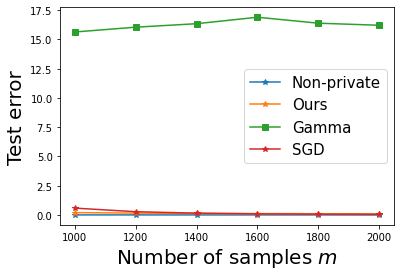

In [6]:
plt.plot(m_range, np.mean(err_np, axis=1), '-*', label='Non-private')
plt.plot(m_range, np.mean(err_ours,axis=1), '-*', label='Ours')
plt.plot(m_range, np.mean(err_chaudi,axis=1), '-s', label='Gamma')
plt.plot(m_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of samples $m$', size=20)
plt.savefig('F1m.pdf', bbox_inches = 'tight')

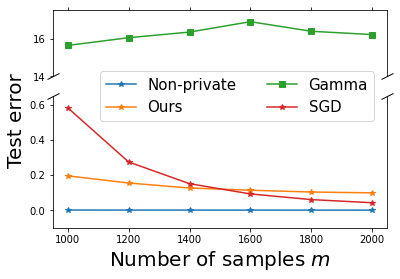

In [16]:
# Plotting function
def plot(ax):
    ax.plot(m_range, np.mean(err_np, axis=1), '-*', label='Non-private')
    ax.plot(m_range, np.mean(err_ours,axis=1), '-*', label='Ours')
    ax.plot(m_range, np.mean(err_chaudi,axis=1), '-s', label='Gamma')
    ax.plot(m_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
    #plt.ylabel('Mean test error', size=20)
    plt.xlabel(r'Number of samples $m$', size=20)

# Draw the graph on two subplots
# Bottom graph is twice the size of the top one
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plot(ax1)
plot(ax2)

# Changes graph axes
ax1.set_ylim(14, 17.5) # Top graph
ax2.set_ylim(-0.1, 0.65) # Bottom graph

# Hides the spines between the axes
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Adds slanted lines to axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.legend(loc='center',bbox_to_anchor=(0.55, 1),fontsize=15,ncol=2)
fig.text(0.02, 0.5, 'Test error', va='center', rotation='vertical', size=20)
plt.savefig('F1m.pdf', bbox_inches = 'tight')

In [17]:
################################ Test function 2
d = 100          # ambient dimension
m_range = range(1000,2200,200)
m_test = 200

gamma = 20     # scaling parameter of Gaussian RF    
epsilon = 1    # private budget
delta = 1e-5   # privacy parameter

K = 10         # repeate K times

err_np = np.zeros( (len(m_range), K) )
err_ours = np.zeros( (len(m_range), K) )
err_chaudi = np.zeros( (len(m_range), K) )
err_obj = np.zeros( (len(m_range), K) )
err_SGD_np = np.zeros( (len(m_range), K) )
err_SGD = np.zeros( (len(m_range), K) )

time_our = np.zeros( (len(m_range), K) )
time_obj = np.zeros( (len(m_range), K) )
time_SGD = np.zeros( (len(m_range), K) )

for i in range(len(m_range)):
    
    m = m_range[i]
    N = 2*m
    Delta_c = 4/np.sqrt(N)    # l2-sensitivity
    
    for j in range(K):
        
        # generate data and random features
        X, Y = generate_data(m+m_test, d, fun1)
        x_train, x_test  = X[:m,:], X[m:,:]
        y_train, y_test = Y[:m], Y[m:]
    
        A_train, A_test = RF_Gaussian(gamma, N, x_train, x_test)

        # our method
        start = time.time()
        #c = np.linalg.pinv(A_train) @ y_train   # non-private
        c = randomized_kaczmarz(A_train, y_train, np.zeros((N,)), m)
        c_ours = private(c, Delta_c, epsilon, delta, "Gaussian")  # private ours
        end = time.time()
        time_our[i,j] = end - start
        err_np[i,j] = np.linalg.norm(y_test - A_test @ c)**2 / m_test
        err_ours[i,j] = np.linalg.norm(y_test - A_test @ c_ours)**2 / m_test
    
        # chaudi
        c_chaudi = private(c, Delta_c, epsilon, delta, "Gamma")
        err_chaudi[i,j] = np.linalg.norm(y_test - A_test @ c_chaudi)**2 / m_test
    
        ## objective perturbation
        reg = 1e-5       # regularization parameter, should be small
        start = time.time()
        c_obj = objective_perturb(epsilon, 2, A_train, y_train, lamb=reg)
        end = time.time()
        time_obj[i,j] = end - start
        err_obj[i,j] = np.linalg.norm(y_test - A_test @ c_obj)**2 / m_test
    
        ## SGD
        eta = 1/m        # learning rate
        T = m            # number of iterations
        start = time.time()
        c_SGD_np, c_SGD = DPRF_SGD(epsilon, delta, A_train, y_train, T, eta)
        end = time.time()
        time_SGD[i,j] = end - start
        err_SGD_np[i,j] = np.linalg.norm(y_test - A_test @ c_SGD_np)**2 / m_test
        err_SGD[i,j] = np.linalg.norm(y_test - A_test @ c_SGD)**2 / m_test

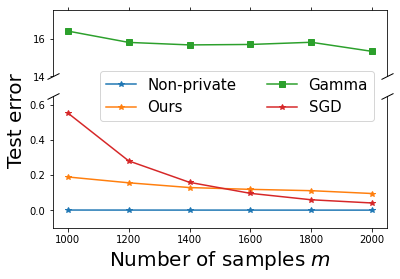

In [18]:
# Plotting function
def plot(ax):
    ax.plot(m_range, np.mean(err_np, axis=1), '-*', label='Non-private')
    ax.plot(m_range, np.mean(err_ours,axis=1), '-*', label='Ours')
    ax.plot(m_range, np.mean(err_chaudi,axis=1), '-s', label='Gamma')
    ax.plot(m_range, np.mean(err_SGD,axis=1), '-*', label='SGD')
    #plt.ylabel('Mean test error', size=20)
    plt.xlabel(r'Number of samples $m$', size=20)

# Draw the graph on two subplots
# Bottom graph is twice the size of the top one
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
plot(ax1)
plot(ax2)

# Changes graph axes
ax1.set_ylim(14, 17.5) # Top graph
ax2.set_ylim(-0.1, 0.65) # Bottom graph

# Hides the spines between the axes
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Adds slanted lines to axes
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
plt.legend(loc='center',bbox_to_anchor=(0.55, 1),fontsize=15,ncol=2)
fig.text(0.02, 0.5, 'Test error', va='center', rotation='vertical', size=20)
plt.savefig('F2m.pdf', bbox_inches = 'tight')

In [ ]:
plt.plot(m_range, np.mean(err_np, axis=1), '-o', label='Non-private')
plt.plot(m_range, np.mean(err_ours,axis=1), '-*', label='Ours')
#plt.plot(m_range, np.mean(err_chaudi,axis=1), '-s', label='Chaudhuri')
#plt.plot(m_range, np.mean(err_obj,axis=1), '-s', label='Objective perturbation')
plt.plot(m_range, np.mean(err_SGD,axis=1), '-s', label='SGD')
plt.legend(fontsize=15)
plt.ylabel('Test error', size=20)
plt.xlabel(r'Number of samples $m$', size=20)
plt.savefig('F2m.pdf', bbox_inches = 'tight')